In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import re
import numpy as np
chrome_options = Options()
browser = webdriver.Chrome('/Users/riomoukiri/Desktop/chromedriver')

In [2]:
#下载数据&拼合数据&格式转换
date_list = list(pd.date_range('20220919','20220923'))
link_list = []
name_list = []
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime('%Y%m%d')
    name_list.append('margin'+date_list[i]+'.xls')
    browser.get('http://www.csf.com.cn/IAutoDisclosure/file/margin'+date_list[i]+'.xls')
total_data = pd.DataFrame(columns = ['日期', '证券代码', '证券名称', '期　限(天)', '融出费率', '融出数量(万股)'])

In [3]:
for i in range(len(name_list)):
    data = pd.read_excel(name_list[i],sheet_name = '转融券交易明细')
    data.columns = data.iloc[0]
    data = data.drop(0)
    data = data.drop(len(data))
    data['序号'] = date_list[i]
    data.columns = ['日期', '证券代码', '证券名称', '期　限(天)', '融出费率', '融出数量(万股)']
    total_data = total_data.append(data)
for i in range(len(total_data)):
    total_data['融出数量(万股)'].iloc[i] = float(re.sub(',','',total_data['融出数量(万股)'].iloc[i] ))
    total_data['融出费率'].iloc[i] = float(re.sub(',','',total_data['融出费率'].iloc[i] ))

In [4]:
#新股检查与保存&去掉新股
total_data['N'] = total_data['证券名称'].str.contains('N')
new = total_data[total_data['N']==True].copy()
del new['N']
new['融出费率']=(new['融出费率']-0.006)*100
new.to_excel('新股.xlsx',index=None)
total_data =total_data[total_data['N']==False].copy()

In [5]:
code_list = [
 '688733.SH',
 '688728.SH',
 '688187.SH',
 '688261.SH',
 '688282.SH',
 '688193.SH',
 '688125.SH',
 '688320.SH',
 '688400.SH',
 '688371.SH',
 '301095.SZ']#这是我方的股票代码
our_stock  = pd.DataFrame(columns = ['日期', '证券代码', '证券名称', '期　限(天)', '融出费率', '融出数量(万股)'])
for i in range(len(code_list)):
    our_stock = our_stock.append(total_data[total_data['证券代码']==re.sub('.SH','',code_list[i])])
our_stock['融出费率'] = (our_stock['融出费率']-0.006)*100
del our_stock['N']
our_stock.to_excel('我们的股票.xlsx',index=None)

In [6]:
#余下的股票
a = total_data.groupby(['证券代码','证券名称']).agg({'融出费率':[min,max],'融出数量(万股)':sum})
b = pd.DataFrame(total_data.groupby(['证券代码','证券名称']))
mean = []
for i in range(len(b)):
    ex = b[1].iloc[i].copy()
    mean.append((ex['融出费率']*ex['融出数量(万股)']).sum()/(ex['融出数量(万股)'].sum()))
a['出借笔数']=total_data.groupby(['证券代码','证券名称']).agg('count')['日期']
a['平均出借利率'] = mean
a=a.reset_index()
a.columns = ['股票代码','股票名称','最低出借利率','最高出借利率','出借总股数(万股)','出借笔数','平均出借利率']
for i in ['最低出借利率','最高出借利率','平均出借利率']:
    a[i] = (a[i]-0.006)*100
a = a[['股票代码','股票名称','最低出借利率','最高出借利率','平均出借利率','出借总股数(万股)','出借笔数']].copy()

In [7]:
#300保存
a['300'] = a['股票代码'].str.contains('^300')
a_300 = a[a['300']==True].copy()[['股票代码','股票名称','最低出借利率','最高出借利率','平均出借利率','出借总股数(万股)','出借笔数']]
a_300.sort_values('平均出借利率',ascending=False).to_excel('300.xlsx',index = None)

In [8]:
#688保存
a['688'] = a['股票代码'].str.contains('^688')
a_688 = a[a['688']==True].copy()[['股票代码','股票名称','最低出借利率','最高出借利率','平均出借利率','出借总股数(万股)','出借笔数']]
a_688.sort_values('平均出借利率',ascending=False).to_excel('688.xlsx',index = None)

In [9]:
import matplotlib
print(matplotlib.matplotlib_fname())

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Heiti TC'] #用来正常显示中文标签
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



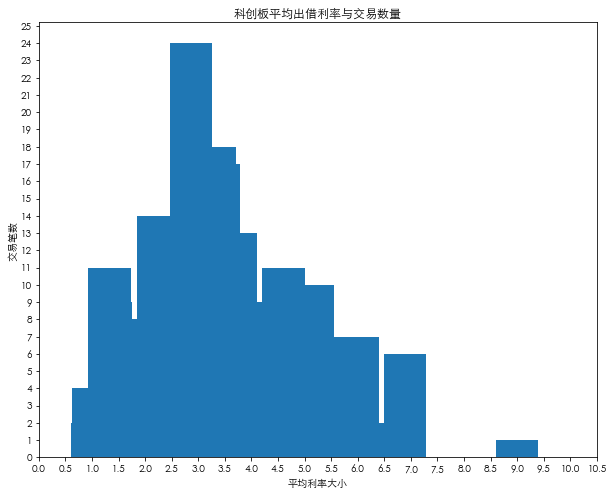

In [11]:
D_300=a_688
D_300['N']=D_300['股票名称'].str.contains("N")
D_300 = D_300[D_300['N']==False]
plt.bar(D_300['平均出借利率'],D_300['出借笔数'] )                           
plt.xlabel('平均利率大小')                           
plt.ylabel('交易笔数') 
plt.yticks([i for i in range(int(D_300['出借笔数'].max()+2))])
plt.xticks([i/2 for i in range((int(D_300['平均出借利率'].max())+2)*2)])
plt.title('科创板平均出借利率与交易数量')
plt.savefig('科创板平均出借利率与交易数量.jpg')

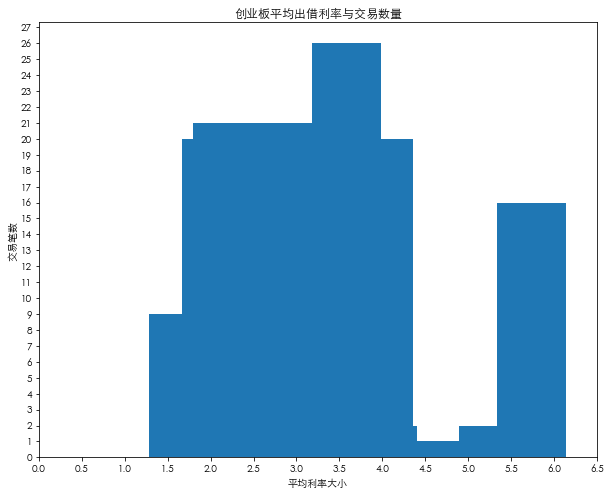

In [12]:
D_300=a_300
D_300['N']=D_300['股票名称'].str.contains("N")
D_300 = D_300[D_300['N']==False]
plt.bar(D_300['平均出借利率'],D_300['出借笔数'] )                                
plt.xlabel('平均利率大小')                           
plt.ylabel('交易笔数') 
plt.yticks([i for i in range(int(D_300['出借笔数'].max()+2))])
plt.xticks([i/2 for i in range((int(D_300['平均出借利率'].max())+2)*2)])
plt.title('创业板平均出借利率与交易数量')
plt.savefig('创业板平均出借利率与交易数量.jpg')